In [ ]:
import pandas as pd
import random
import numpy as np
import tqdm
import matplotlib.pyplot as plt

## Generate CSV input

In [11]:
num_people = 5000
num_zones = 5
random.seed(0)

example_input = pd.DataFrame(data={
    'name': [f'Person {n+1}' for n in range(num_people)],
    'zone': [f'Zone {n+1}' for n in random.choices(range(num_zones), k=num_people)]
})

example_input.to_csv('example_csv_input.csv', index=False)

## Generate random solutions

In [148]:
def evaluate_result(result):
    num_people = len(result['person'].unique())
    role_counts = result.pivot_table(index='person', columns='role', values='week', aggfunc='count', fill_value=0).values
    table_counts = result.pivot_table(index='person', columns='table', values='week', aggfunc='count', fill_value=0).values
    collaboration_counts = np.zeros((num_people, num_people))

    for members in result.groupby(['zone', 'week', 'group'])['person'].apply(lambda x: x.tolist()).tolist():
        idx = np.array(np.meshgrid(members, members)).T.reshape(-1, 2)
        idx = idx[idx[:, 0] != idx[:, 1]] - 1
        collaboration_counts[idx[:,0], idx[:, 1]] += 1

    return {
        'mean_collaboration_count': collaboration_counts[collaboration_counts > 0].mean().item(),
        'mean_role_count': role_counts[role_counts > 0].mean().item(),
        'mean_table_count': table_counts[table_counts > 0].mean().item()
    }

In [149]:
optimization_result = pd.read_csv('optimization_result.csv')
optimization_result['person'] = pd.factorize(optimization_result['person'])[0]
optimization_metrics = evaluate_result(optimization_result)

random_metrics = []

for i in tqdm.trange(100):
    random_result = optimization_result.copy()
    
    # within each zone, and week, shuffle the people
    random_result['person'] = random_result.groupby(['zone', 'week'])['person'].transform(
        lambda x: np.random.permutation(x.values)
    )

    random_metrics.append(evaluate_result(random_result))

random_metrics = pd.DataFrame(random_metrics)

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


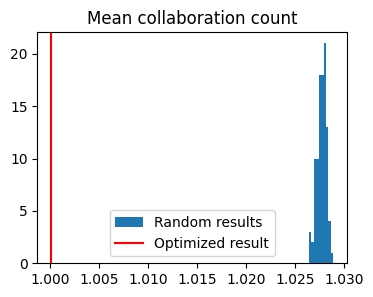

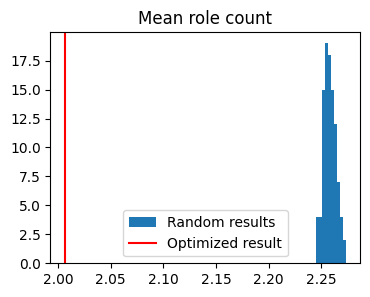

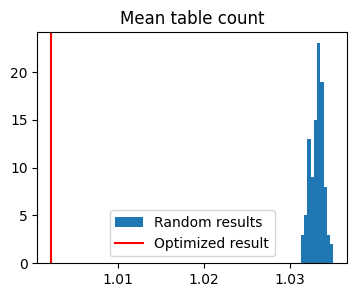

In [151]:
for metric in ['mean_collaboration_count', 'mean_role_count', 'mean_table_count']:
    plt.figure(figsize=(4, 3))
    plt.title(metric.replace('_', ' ').capitalize())
    plt.hist(random_metrics[metric], label='Random results')
    plt.axvline(x=optimization_metrics[metric], color='red', label='Optimized result')
    plt.legend()
    plt.show()
